In [2]:
import numpy as np

from scipy.signal import butter, lfilter, hilbert, sosfilt
import matplotlib.pyplot as plt
import soundfile as sf

from pydub import AudioSegment

In [22]:
# Butterworth Bandpass Filter Design
def butter_bandpass(lowcut, highcut, fs, order=4):
    print(fs)
    nyquist = 0.5 * fs
    
    if not (0 < lowcut < nyquist and 0 < highcut < nyquist):
        raise ValueError("Cutoff frequencies must be between 0 and the Nyquist frequency.")
    
    if highcut - lowcut < 1:  # Adjust threshold as needed for stability
        print("Warning: Narrow bandwidth detected. Consider lowering filter order.")
        order = min(order, 2)  # Reduce order for stability
    
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')

    return sos


def bandpass_filter(data, lowcut, highcut, fs, order=4):
    if np.any(np.isnan(data)) or np.any(np.isinf(data)):
        raise ValueError("Input data contains NaN or Inf values.")
    max_val = np.max(np.abs(data))

    assert max_val < 1e6, print("Very large values found before filtering")
    # if max_val > 1e6:  # Threshold for large amplitude signals
    #     print("Warning: Large signal amplitude detected. Normalizing input.")
    #     data = data / max_val
    #     b, a = butter_bandpass(lowcut, highcut, fs, order)
    #     return lfilter(b, a, data)*max_val

    sos = butter_bandpass(lowcut, highcut, fs, order)

    return sosfilt(sos, data)

True
48000
48000


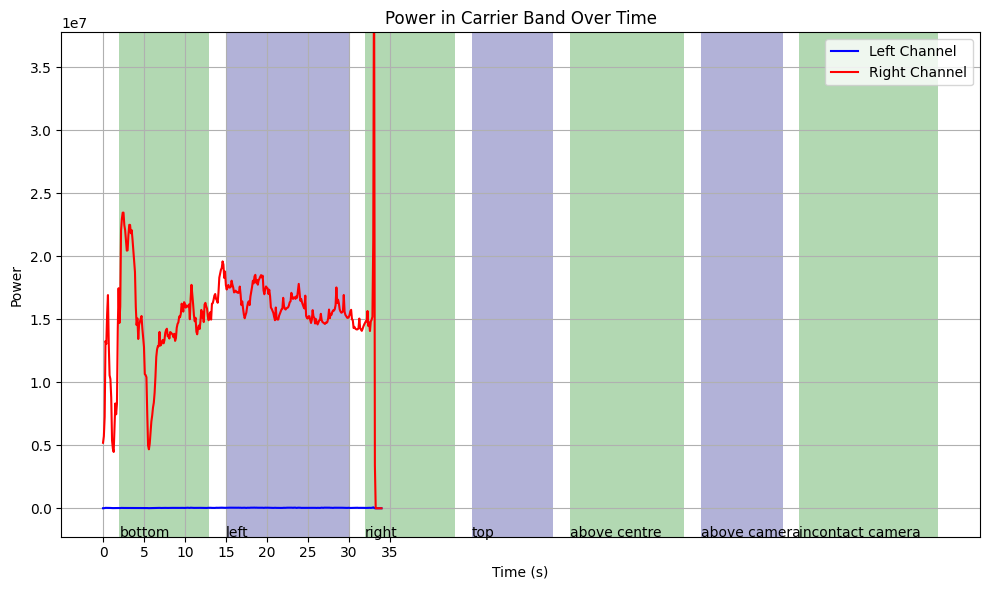

48000
48000
48000
48000


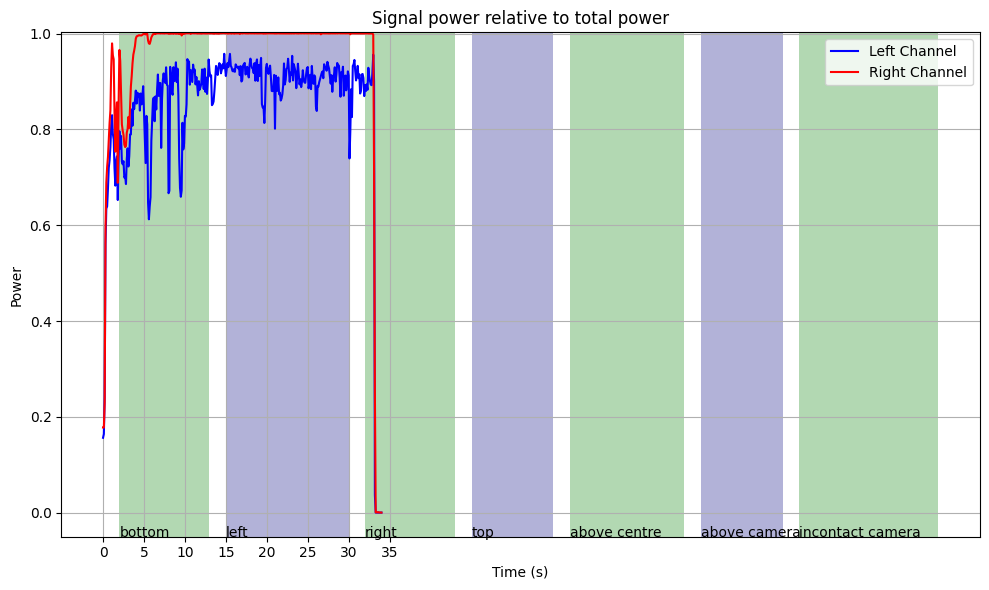

In [28]:



def calculate_power_in_band(data, fs, lowcut, highcut, segment_duration=0.1):
    """
    Calculate the power in a specific frequency band over time.
    
    Args:
        data (np.ndarray): Input signal (1D array).
        fs (int): Sampling frequency.
        lowcut (float): Lower cutoff frequency of the bandpass filter.
        highcut (float): Upper cutoff frequency of the bandpass filter.
        segment_duration (float): Duration of each time segment in seconds.
    
    Returns:
        np.ndarray: Array of power values over time.
        np.ndarray: Time vector corresponding to the power values.
    """
    # Bandpass filter the signal
    bandpassed = bandpass_filter(data, lowcut, highcut, fs)
    
    # Calculate the envelope of the bandpassed signal using the Hilbert transform
    envelope = np.abs(hilbert(bandpassed))
    
    # Calculate power in segments
    segment_samples = int(segment_duration * fs)
    num_segments = len(data) // segment_samples
    power = np.array([
        np.mean(envelope[i * segment_samples:(i + 1) * segment_samples] ** 2)
        for i in range(num_segments)
    ])
    time = np.arange(num_segments) * segment_duration
    return power, time

def plot_power_over_time(time, power_left, power_right, text_dict=None, title='Power in Carrier Band Over Time'):
    """Plot power over time for both channels."""
    mint = 0
    maxt = np.ceil(np.max(time)/10)*10
    power_max = np.max([np.max(power_left), np.max(power_right)])
    power99 = np.max([np.quantile(power_left, 0.999), np.quantile(power_right, 0.999)])
    plt_time = np.arange(mint, maxt, 5)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111) 
    colours = [(0,0.5,0),(0,0,0.5)]
    i = 0
    if text_dict is not None:
        from matplotlib.patches import Rectangle
        for rectangle in text_dict:

            x1 = rectangle['start']
            x2 = rectangle['end']
            width = x2-x1
            cx = x1 + width/2
            #Rectangle((x1, -power_max/10), width, power_max*1.1, fc = colours[i%2], fill=True)
            rect = Rectangle((x1, -power_max/10), width, power_max*1.1, fc = colours[i%2], fill=True, alpha=0.3)
            ax.add_patch(rect) 
            plt.text(x1, -power_max/20, rectangle['text'])
            i += 1

    plt.plot(time, power_left, label='Left Channel', color='blue')
    plt.plot(time, power_right, label='Right Channel', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.ylim([-power_max/20, power99])
    plt.xticks(plt_time)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# --- Testing Script ---
def analyze_stereo_recording(file_path, lowcut, highcut, segment_duration=0.1, text_dict=None):
    """
    Analyze a stereo recording to calculate and plot the power in the carrier band.
    
    Args:
        file_path (str): Path to the stereo audio file.
        lowcut (float): Lower cutoff frequency of the carrier band.
        highcut (float): Upper cutoff frequency of the carrier band.
        segment_duration (float): Duration of each time segment in seconds.
    """
    audio = AudioSegment.from_file(file_path)
    # audio = audio.set_frame_rate(SAMPLE_RATE)

    # Extract raw audio data
    data = np.array(audio.get_array_of_samples(), dtype=np.float32).reshape(-1, audio.channels)
    fs = audio.frame_rate
    # Load stereo audio file
    #data, fs = sf.read(file_path)
    if len(data.shape) != 2 or data.shape[1] != 2:
        raise ValueError("Input file must be a stereo recording.")
    
    # Separate left and right channels
    left_channel = data[:, 0]
    right_channel = data[:, 1]
    
    # Calculate power in the carrier band for each channel
    power_left, time = calculate_power_in_band(left_channel, fs, lowcut, highcut, segment_duration)
    power_right, _ = calculate_power_in_band(right_channel, fs, lowcut, highcut, segment_duration)
    
    # Plot power over time
    plot_power_over_time(time, power_left, power_right, text_dict)

def analyze_stereo_recording_in_vs_out_band(file_path, lowcut, highcut, segment_duration=0.1, text_dict=None):
    """
    Analyze a stereo recording to calculate and plot the power in the carrier band.
    
    Args:
        file_path (str): Path to the stereo audio file.
        lowcut (float): Lower cutoff frequency of the carrier band.
        highcut (float): Upper cutoff frequency of the carrier band.
        segment_duration (float): Duration of each time segment in seconds.
    """
    audio = AudioSegment.from_file(file_path)
    # audio = audio.set_frame_rate(SAMPLE_RATE)

    # Extract raw audio data
    data = np.array(audio.get_array_of_samples(), dtype=np.float32).reshape(-1, audio.channels)
    fs = audio.frame_rate
    # Load stereo audio file
    #data, fs = sf.read(file_path)
    if len(data.shape) != 2 or data.shape[1] != 2:
        raise ValueError("Input file must be a stereo recording.")
    
    # Separate left and right channels
    left_channel = data[:, 0]
    right_channel = data[:, 1]
    
    # Calculate power in the carrier band for each channel
    power_left, time = calculate_power_in_band(left_channel, fs, lowcut, highcut, segment_duration)
    power_left_total, time = calculate_power_in_band(left_channel, fs, 20, 22000, segment_duration)
    power_right, _ = calculate_power_in_band(right_channel, fs, lowcut, highcut, segment_duration)
    power_right_total, _ = calculate_power_in_band(right_channel, fs, 20, 22000, segment_duration)
    
    # Plot power over time
    plot_power_over_time(time, power_left/power_left_total, power_right/power_right_total, text_dict, title='Signal power relative to total power')


# Example Usage

import os
file_path = r"C:\\Users\\joshu\\Downloads\\Similtaneous ECG 1 2024-12-11 140800.m4a"
file_path = r"C:\\Users\\joshu\\Downloads\\ECG mic test moving.m4a"
file_path = r"C:\\Users\\joshu\\Downloads\\ECG clean.m4a"
print(os.path.exists(file_path))

#file_path = "path_to_your_stereo_audio_file.wav"
lowcut = 18000  # Lower bound of the carrier band (e.g., 18 kHz)
highcut = 20000  # Upper bound of the carrier band (e.g., 20 kHz)
segment_duration = 0.1  # Analyze power in 0.1-second segments


text_dict = [{'text': 'bottom', 'start': 2, 'end':13},{'text': 'left', 'start': 15, 'end':30},{'text': 'right', 'start': 32, 'end':43},{'text': 'top', 'start': 45, 'end':55},{'text': 'above centre', 'start': 57, 'end':71}, {'text': 'above camera', 'start': 73, 'end':83},{'text': 'incontact camera', 'start': 85, 'end':102}]


analyze_stereo_recording(file_path, lowcut, highcut, segment_duration, text_dict)
analyze_stereo_recording_in_vs_out_band(file_path, lowcut, highcut, segment_duration=0.1, text_dict=text_dict)
